# Overview
This document aims to give an overview of the progress on the project of predicting vapour pressure using MDFPs with code and data

## Baseline
As a first step, an updated conda environment was created used to generate about a single 3D conformer for about 3000 molecules, which were  simulated in water for 5 nanoseconds. The molecules were previously curated by Dr. ShuZe Wang. All conformers are stored in the public database "conformers" and all relevant data is stored in schema cs_mdf_schema.

In [1]:
import sys
sys.path.append('../')
from carl.utils_carl import get_mdfps
df_mdfps = get_mdfps(which='one_5ns')

2993 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


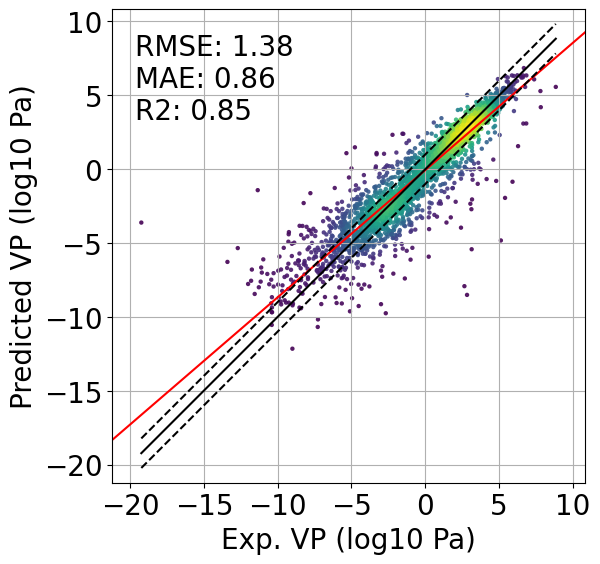

In [2]:
from utils_carl import train_pred_xgboost,density_plot,getStatValues,density_plot_multiple
from functools import reduce
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5) #we do 5-fold cross-validation
real_one_to_one, prediction_one_to_one = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real_one_to_one,prediction_one_to_one,print_stats=False)

We get decent predictions, in line with results obtained by ShuZe

## Using multiple starting conformers

We perform a few tests assing:
1. The performance of model trained on one conformer on different conformers from the same molecule
2. Does data augmentation with multiple starting conformers per mol improve the performance

### Predictive ability towards new conformers

In [3]:
#train model on one conformer of all molecules
import xgboost as xgb
import numpy as np
train_x = np.array(df_mdfps['mdfp'].tolist())
train_y = np.array(df_mdfps['vp'].tolist())
dtrain = xgb.DMatrix(train_x, label=train_y)
model_trained_oneconf_per_mol = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    verbose_eval=False
)

In [4]:
#Fetch all conformers that were generated in the second round (using RDKit EmbedMultipleConfs, and picked diverse using MaxMin algorithm)
df_new_confs = get_mdfps(which='five_5ns')

11089 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [5]:
import numpy as np
import xgboost as xgb
test_x = np.array(df_new_confs['mdfp'].tolist())
real_one_to_many_confs = np.array(df_new_confs['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=real_one_to_many_confs)
preds_one_to_many_same_mol = model_trained_oneconf_per_mol.predict(dtest)

Because we use a different random seed for creating these new conformers, some conformers are actually structually the same as the 'old' conformers, but are registered as new as they have different coordinates. While this is technically a mistake and a waste or resources, we can use this as an oppurtunity to look at the impact at the simulation level of two same starting conformers

In [6]:
import pickle   
with open('duplicate_confids.pkl', 'rb') as f:
    duplicate_confids = pickle.load(f)
df_new_confs_no_dups = df_new_confs[~df_new_confs['confid'].isin(duplicate_confids)]
print(len(df_new_confs_no_dups), len(df_new_confs))
test_x = np.array(df_new_confs_no_dups['mdfp'].tolist())
test_y_no_dups = np.array(df_new_confs_no_dups['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y_no_dups)
preds_one_to_many_same_mol_no_dups = model_trained_oneconf_per_mol.predict(dtest)
df_new_confs_only_dups = df_new_confs[df_new_confs['confid'].isin(duplicate_confids)]
print(len(df_new_confs_only_dups), len(df_new_confs))
test_x = np.array(df_new_confs_only_dups['mdfp'].tolist())
test_y_dups = np.array(df_new_confs_only_dups['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y_dups)
preds_dups = model_trained_oneconf_per_mol.predict(dtest)



10621 11089
468 11089


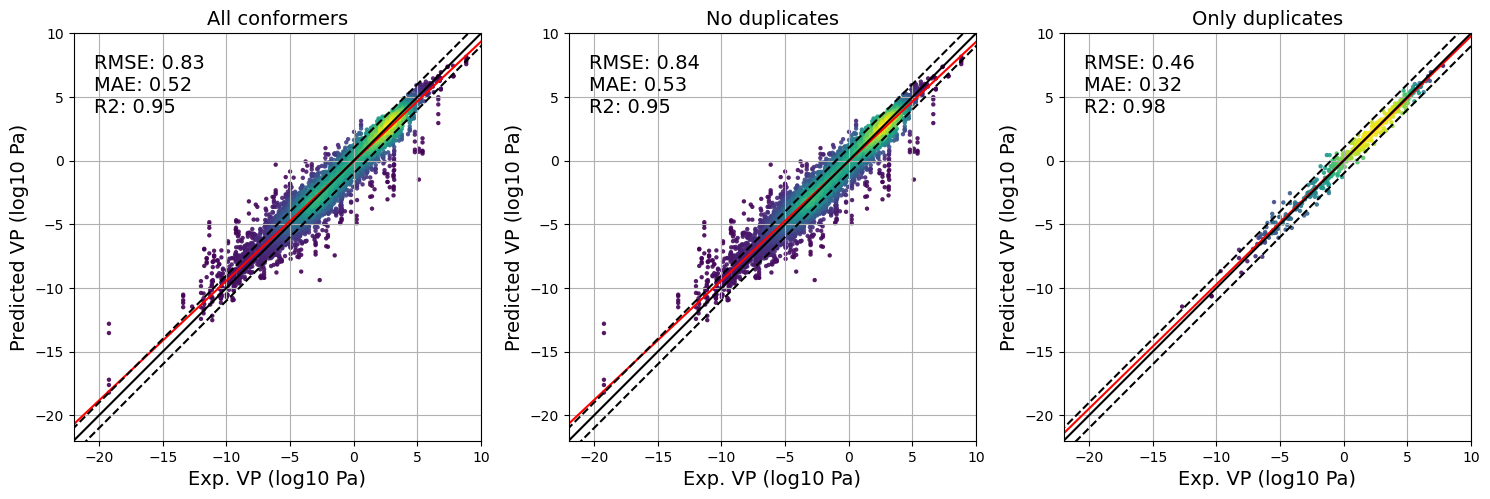

In [7]:
reals_lol = [real_one_to_many_confs, test_y_no_dups, test_y_dups]
preds_lol = [preds_one_to_many_same_mol, preds_one_to_many_same_mol_no_dups, preds_dups]
density_plot_multiple(reals_lol, preds_lol,titles = ['All conformers', 'No duplicates', 'Only duplicates'], bounds = [-22,10],print_stats=False)

In [8]:
data_full = get_mdfps(which='all')

14083 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [9]:
#get all molregnos from data_full that appear 5 or more times
import pandas as pd
molregnos = data_full['molregno'].value_counts()
molregnos = molregnos[molregnos == 6].index.tolist()
print(f'{len(molregnos)} molregnos with 6 conformers')
df_6_confs = data_full[data_full['molregno'].isin(molregnos)].copy()
#make another df with the rest of the data
#split data in six folds so that each fold has at least one conformer of each molregno
df_6_confs['fold'] = np.nan
for molregno in molregnos:
    #assign a fold to each conformer of this molregno
    df_6_confs.loc[df_6_confs['molregno'] == molregno, 'fold'] = np.arange(6)
df_6_confs['fold'] = df_6_confs['fold'].astype(int)
#check if each fold has at least one conformer of each molregno
for molregno in molregnos:
    if len(df_6_confs[df_6_confs['molregno'] == molregno]['fold'].unique()) != 6:
        print(f'molregno {molregno} not in each fold')
        break
train_base = data_full[~data_full['molregno'].isin(molregnos)].copy()
#check overlap between train_base and df_6_confs for confids 
train_base_confids = train_base['confid'].tolist()
df_6_confs_confids = df_6_confs['confid'].tolist()
overlap = set(train_base_confids).intersection(df_6_confs_confids)
print(f'Overlap: {len(overlap)}')
output = ([],[],[],[])
for fold in range(6):
    #get test data for this fold
    test = df_6_confs[df_6_confs['fold'] == fold].copy()
    #the rest to train
    train = df_6_confs[df_6_confs['fold'] != fold].copy()
    #add train_base to train
    train = pd.concat([train, train_base], ignore_index=True)
    
    #get the mdfps and vps of the conformers for this fold
    test_x = np.array(test['mdfp'].tolist())
    test_y = np.array(test['vp'].tolist())
    train_x = np.array(train['mdfp'].tolist())
    train_y = np.array(train['vp'].tolist())

    #check if no overlap of confids between test and train
    if len(set(test['confid']).intersection(set(train['confid']))) != 0:
        print('overlap between test and train: ', len(set(test['confid']).intersection(set(train['confid']))))
        break

    #get molregnos test
    molregnos_test = test['molregno'].tolist()
    #get confids test
    confids_test = test['confid'].tolist()
   

    # Create DMatrix for training and testing
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    output[2].append(molregnos_test)
    output[3].append(confids_test)


1704 molregnos with 6 conformers
Overlap: 0


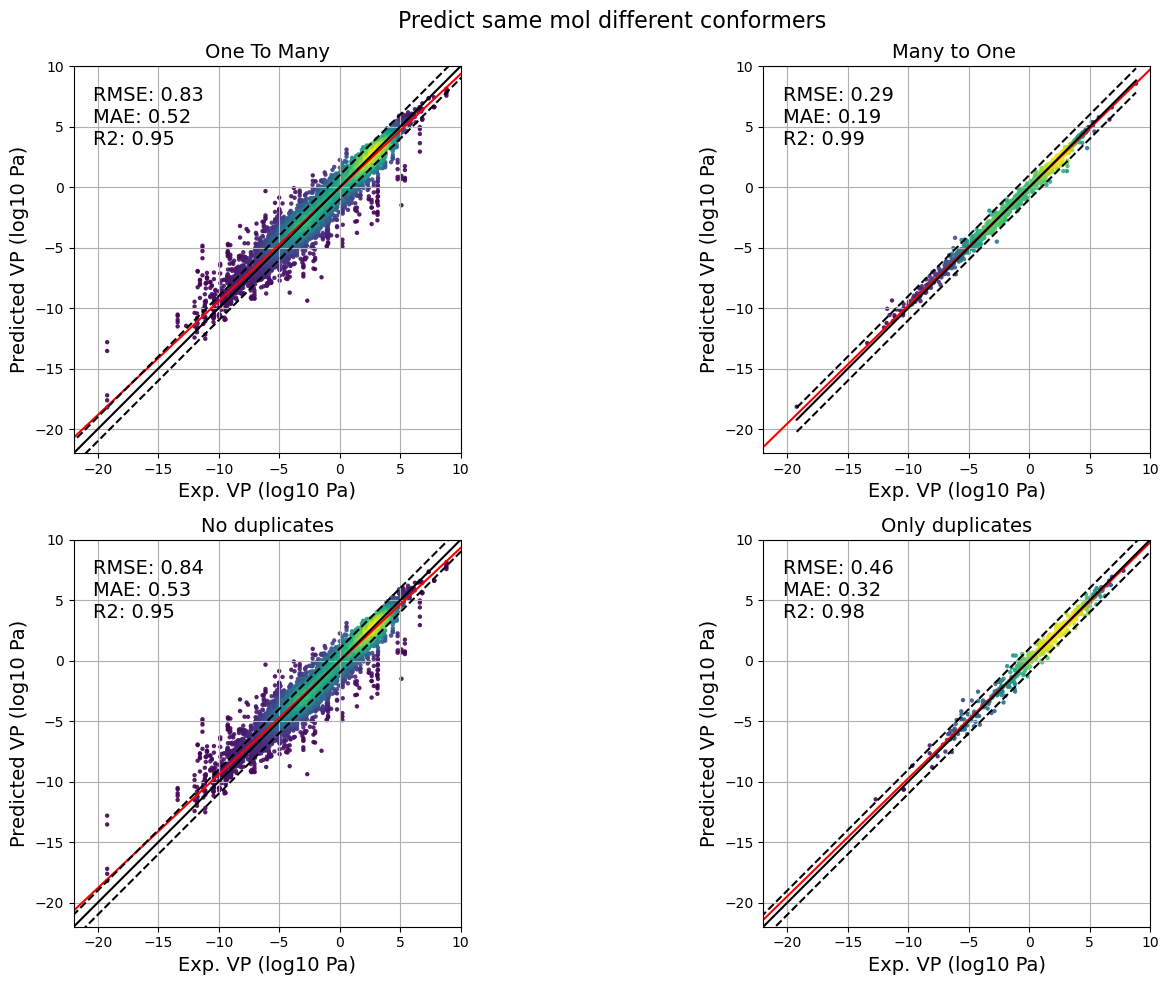

In [11]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction_train_5_confs_pred_6 = df_preds['pred'].tolist()
real_train_5_confs_pred_6 = df_preds['vp'].tolist()

reals_lol = [real_one_to_many_confs, real_train_5_confs_pred_6,test_y_no_dups, test_y_dups]
preds_lol = [preds_one_to_many_same_mol, prediction_train_5_confs_pred_6,preds_one_to_many_same_mol_no_dups, preds_dups]
density_plot_multiple(reals_lol, preds_lol,titles = ['One To Many','Many to One ','No duplicates', 'Only duplicates'], bounds = [-22,10],print_stats=False,global_title="Predict same mol different conformers")


So predicting the vapour pressure for a different starting conformer of the same molecule works quite well when looking at the correlation, but there is still quite a big RMSE.

### Data augmentation

In [13]:
data_full = get_mdfps(which='all')

14083 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [14]:
params = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
output = train_pred_xgboost(data_full,params,return_confids=True)
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction_many_to_many = df_preds['pred'].tolist()
real_many_to_many = df_preds['vp'].tolist()

Data augmentation resulted in a decrease in error metrics RMSE and MAE but not much in correlation

now look at the four scenarios for new mols:
1. many to many (split by molregno on data_full)
2. many to one (train on df_new_confs, predict df_mdfps. Look at with and without removing duplictes)
3. one to many (train on df_mdfps, pred df_new_confs)
4. one to one (split by molregno on df_mdfps)



In [15]:
#fairest if we compare the same number of conformers. So maybe first split data_full into five folds. For each fold, check how many unique molregnos and how many conf_ids
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []

# Group the data by 'molregno'
groups = data_full['molregno']
params_one = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
params_many = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
# Iterate over each fold
outputs = ([],[],[],[],[],[],[],[],[],[],[])

for train_idx, test_idx in gkf.split(data_full, groups=groups):
    #first we split the whole data by molregno
    train_all = data_full.iloc[train_idx]
    test_all = data_full.iloc[test_idx]

    #then we make a seperate set with only one conformer per molregno
    molregnos_train = train_all['molregno'].unique().tolist()
    confids_train = []
    for molregno in molregnos_train:
        confids = train_all[train_all['molregno'] == molregno]['confid'].tolist()
        confids_train.append(np.random.choice(confids, 1)[0])
    train_one_to_one = train_all[train_all['confid'].isin(confids_train)].copy()

    molregnos_test_one = test_all['molregno'].unique().tolist()
    molregnos_test_many = test_all['molregno'].tolist()
    confids_test_all = test_all['confid'].tolist()
    confids_test_one = []
    confids_test_many = test_all['confid'].tolist()
    for molregno in molregnos_test_one:
        confids = test_all[test_all['molregno'] == molregno]['confid'].tolist()       
        confids_test_one.append(np.random.choice(confids, 1)[0])
    test_one_to_one = test_all[test_all['confid'].isin(confids_test_one)].copy()

    train_x_one = np.array(train_one_to_one['mdfp'].tolist())
    train_y_one = np.array(train_one_to_one['vp'].tolist())
    dtrain_one = xgb.DMatrix(train_x_one, label=train_y_one)
    
    test_x_one = np.array(test_one_to_one['mdfp'].tolist())
    test_y_one = np.array(test_one_to_one['vp'].tolist())
    dtest_one = xgb.DMatrix(test_x_one, label=test_y_one)

    train_x_many = np.array(train_all['mdfp'].tolist())
    train_y_many = np.array(train_all['vp'].tolist())
    dtrain_many = xgb.DMatrix(train_x_many, label=train_y_many)

    test_x_many = np.array(test_all['mdfp'].tolist())
    test_y_many = np.array(test_all['vp'].tolist())
    dtest_many = xgb.DMatrix(test_x_many, label=test_y_many)

    #now for all four, train models and predict
    model_one = xgb.train(
        params_one,
        dtrain_one,
        num_boost_round=999,
        verbose_eval=False
    )
    model_many = xgb.train(
        params_many,
        dtrain_many,
        num_boost_round=999,
        verbose_eval=False
    )
    preds_one_to_one = model_one.predict(dtest_one)
    preds_many_to_many = model_many.predict(dtest_many)

    preds_one_to_many = model_one.predict(dtest_many)
    preds_many_to_one = model_many.predict(dtest_one)

    outputs[0].append(preds_one_to_one)
    outputs[1].append(preds_many_to_many)
    outputs[2].append(preds_one_to_many)
    outputs[3].append(preds_many_to_one)

    outputs[4].append(test_y_one)
    outputs[5].append(test_y_many)

    outputs[6].append(molregnos_test_one)
    outputs[7].append(molregnos_test_many)

    outputs[8].append(confids_test_one)
    outputs[9].append(confids_test_many)

    #check output lengths: all 'many' should be equal and all 'one' should be equal
    if len(preds_one_to_one) != len(preds_many_to_one) != len(test_y_one) != len(molregnos_test_one) != len(confids_test_one):
        print('lengths not equal')
        print(len(preds_one_to_one), len(preds_many_to_one), len(test_y_one), len(molregnos_test_one), len(confids_test_one))
        break
    if len(preds_many_to_many) != len(preds_one_to_many) != len(test_y_many) != len(molregnos_test_many) != len(confids_test_many):
        print('lengths not equal')
        print(len(preds_many_to_many), len(preds_one_to_many), len(test_y_many), len(molregnos_test_many), len(confids_test_many))
        break


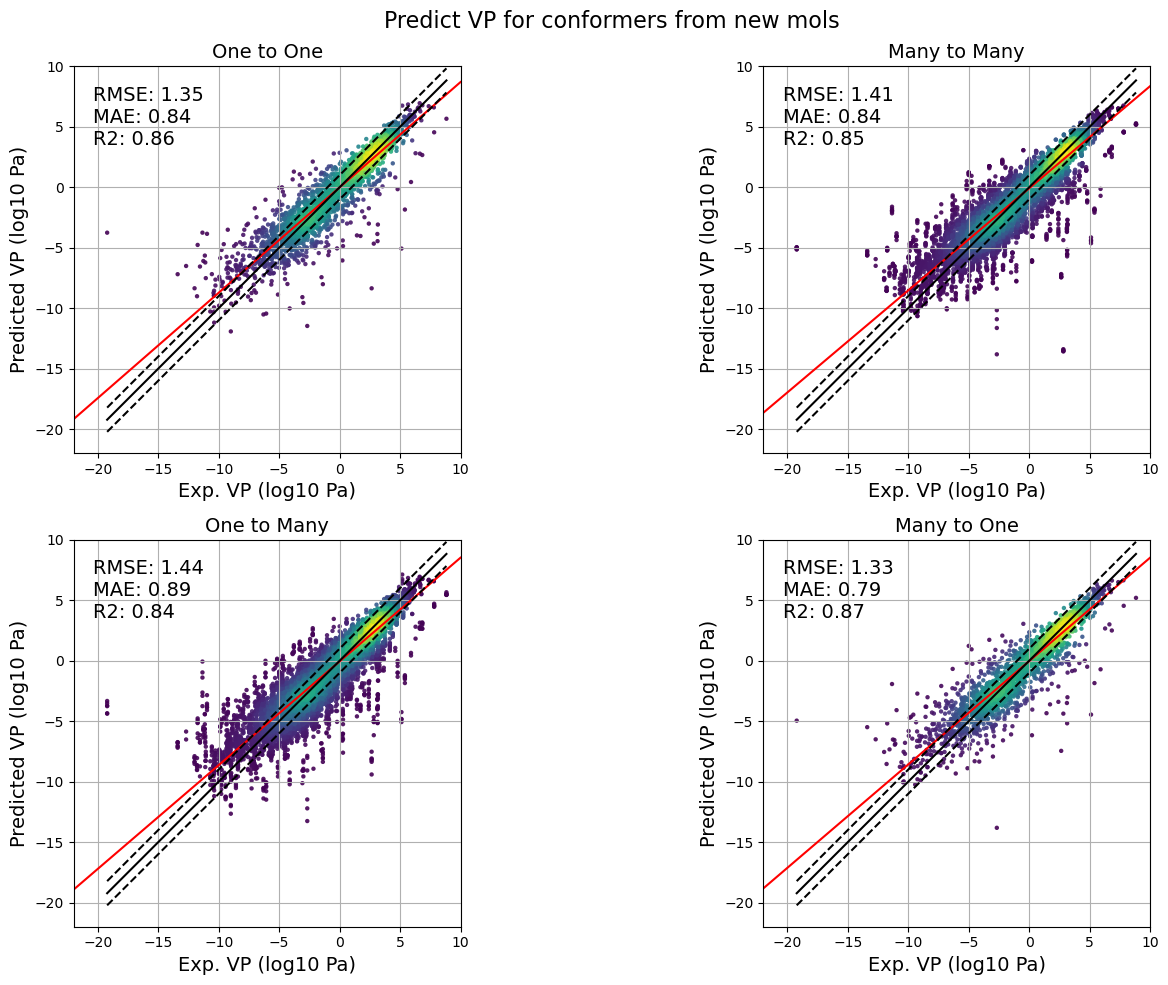

In [16]:
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])

pred_lol = [preds_one_to_one, preds_many_to_many, preds_one_to_many, preds_many_to_one]
real_lol = [test_y_one, test_y_many, test_y_many, test_y_one]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple(real_lol, pred_lol, titles=titles, bounds = [-22,10], print_stats=False,global_title="Predict VP for conformers from new mols")

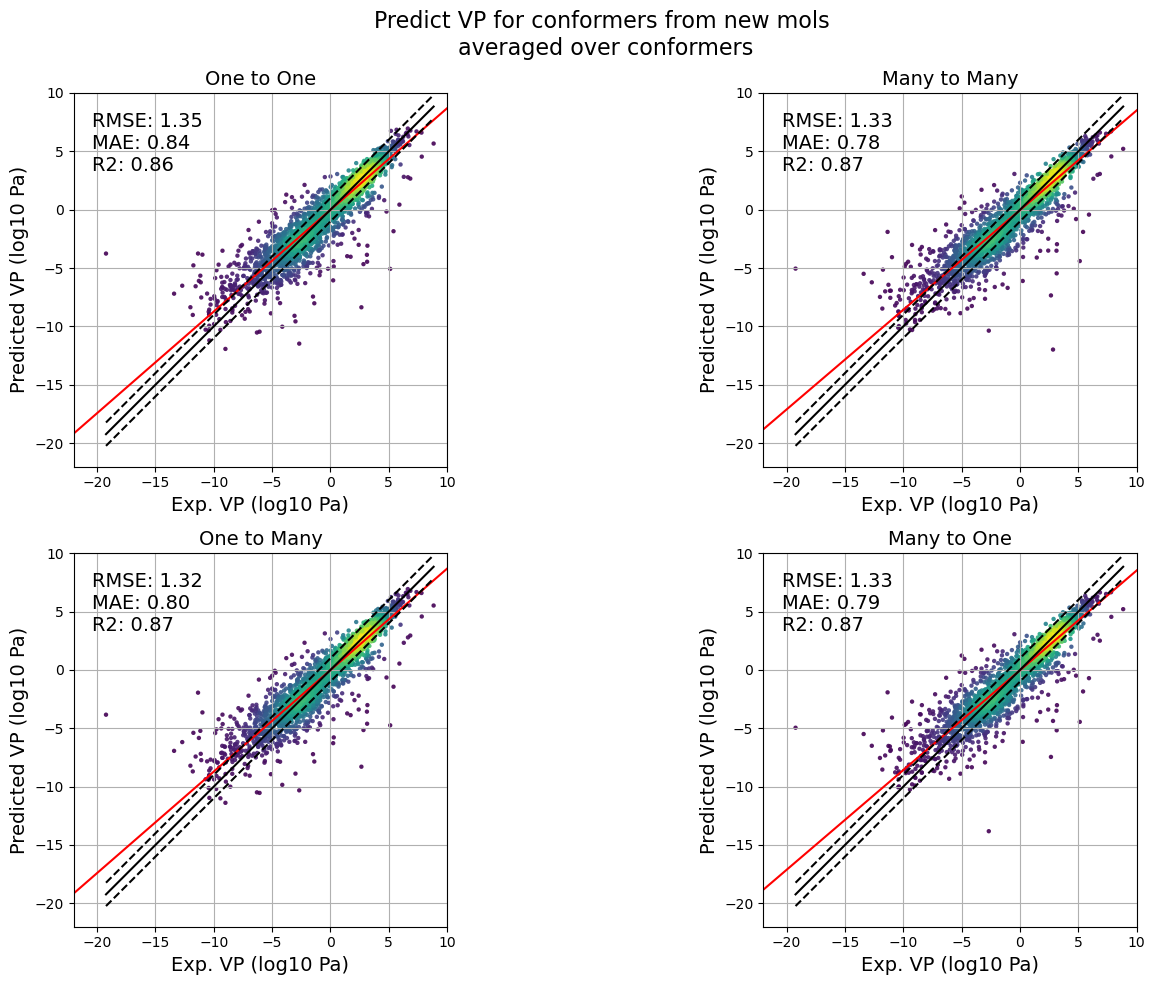

In [30]:
#repeat with averging for the many. 
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])
molregnos_one = reduce(lambda a,b : list(a)+list(b), outputs[6])
molregnos_many = reduce(lambda a,b : list(a)+list(b), outputs[7])
confids_test_one = reduce(lambda a,b : list(a)+list(b), outputs[8])
confids_test_all = reduce(lambda a,b : list(a)+list(b), outputs[9])

df_preds_one_to_one = pd.DataFrame({'vp': test_y_one, 'pred': preds_one_to_one, 'confid': confids_test_one, 'molregno': molregnos_one})
df_preds_one_to_one = df_preds_one_to_one.groupby('molregno').mean()
preds_one_to_one_mean = df_preds_one_to_one['pred'].tolist()
test_y_one_mean = df_preds_one_to_one['vp'].tolist()

df_preds_many_to_many = pd.DataFrame({'vp': test_y_many, 'pred': preds_many_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_many_to_many = df_preds_many_to_many.groupby('molregno').mean()
preds_many_to_many_mean = df_preds_many_to_many['pred'].tolist()
test_y_many_mean = df_preds_many_to_many['vp'].tolist()

df_preds_one_to_many = pd.DataFrame({'vp': test_y_many, 'pred': preds_one_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_one_to_many = df_preds_one_to_many.groupby('molregno').mean()
preds_one_to_many_mean = df_preds_one_to_many['pred'].tolist()
test_y_many_mean = df_preds_one_to_many['vp'].tolist()

df_preds_many_to_one = pd.DataFrame({'vp': test_y_one, 'pred': preds_many_to_one, 'confid': confids_test_one, 'molregno': molregnos_one})
df_preds_many_to_one = df_preds_many_to_one.groupby('molregno').mean()
preds_many_to_one_mean = df_preds_many_to_one['pred'].tolist()
test_y_one_mean = df_preds_many_to_one['vp'].tolist()

pred_lol = [preds_one_to_one_mean, preds_many_to_many_mean, preds_one_to_many_mean, preds_many_to_one_mean]
real_lol = [test_y_one_mean, test_y_many_mean, test_y_many_mean, test_y_one_mean]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple(real_lol, pred_lol, titles=titles, bounds = [-22,10], print_stats=False,global_title="Predict VP for conformers from new mols \naveraged over conformers")

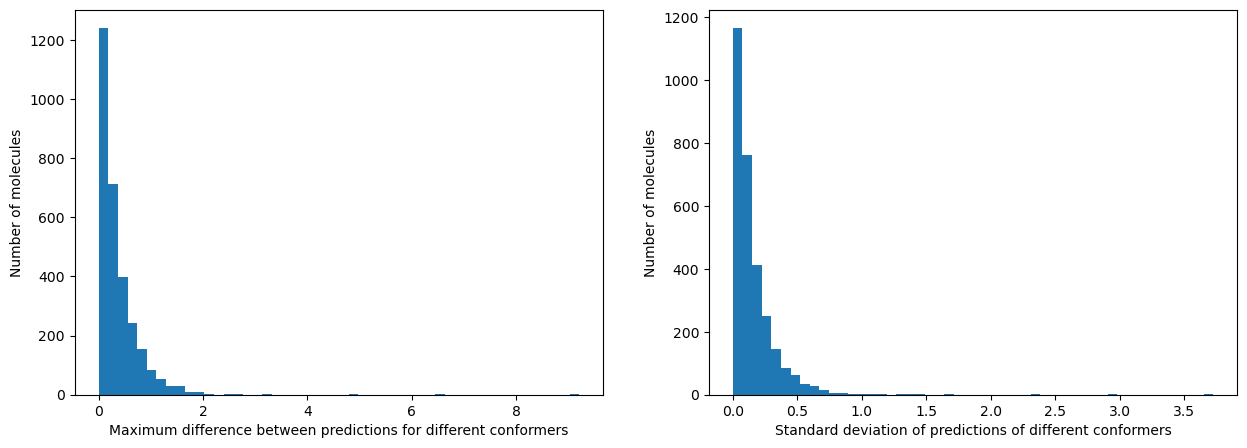

In [35]:
df_preds_many_to_many = pd.DataFrame({'vp': test_y_many, 'prediction': preds_many_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_many_to_many.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/many_to_many.csv', index=False)
max_diffs = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['max','min']})
max_diffs['diff'] = max_diffs['prediction']['max'] - max_diffs['prediction']['min']
max_diffs_list = max_diffs['diff'].tolist()
stds = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['std']})
max_diffs_list = [diff for diff in max_diffs_list if diff != 0]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(max_diffs_list, bins=50)
axs[0].set_xlabel('Maximum difference between predictions for different conformers')
axs[0].set_ylabel('Number of molecules')
axs[1].hist(stds['prediction']['std'].tolist(), bins=50)
axs[1].set_xlabel('Standard deviation of predictions of different conformers')
axs[1].set_ylabel('Number of molecules')
plt.show()


As shown in Experiments_error_analysis/002_errors_from_flexibility.ipynb, the number of rotatable bonds does not seem to be directly correlated to the error of prediction